In [1]:
import os
import warnings
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, get_linear_schedule_with_warmup, pipeline
from transformers import logging as transformers_logging
from tqdm.auto import tqdm
from collections import Counter

2026-01-15 10:55:53.198207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768474553.417535      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768474553.482734      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768474553.989410      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768474553.989473      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768474553.989477      24 computation_placer.cc:177] computation placer alr

In [2]:
warnings.filterwarnings('ignore')
transformers_logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0
print(f"Device: {device}, Number of GPUs: {n_gpu}")

Device: cuda, Number of GPUs: 2


In [4]:
EPOCHS = 4
DATA_PATH = "/kaggle/input/arabic-qa-cleaned/data_cleaned.csv"
MODELS_CONFIG = {
    "AraELECTRA-base": {
        "checkpoint": "aubmindlab/araelectra-base-discriminator",
        "batch_size": 16,
        "lr": 5e-5,
        "grad_accum": 2
    }
}

In [5]:
print("Loading and splitting data...")
df = pd.read_csv(DATA_PATH).dropna()
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Loading and splitting data...
Train: 154768, Val: 19346, Test: 19346


In [6]:
def encode_example(row, tokenizer, max_len=384):
    question = str(row["question"])
    context = str(row["context"])
    answer = str(row["answer"])
    start_char = context.find(answer)
    if start_char == -1:
        return None
    inputs = tokenizer(
        question,
        context,
        truncation="only_second",
        max_length=max_len,
        padding="max_length",
        return_offsets_mapping=True
    )
    offsets = inputs["offset_mapping"]
    start_token, end_token = None, None
    for i, (s, e) in enumerate(offsets):
        if s <= start_char < e:
            start_token = i
        if s < start_char + len(answer) <= e:
            end_token = i
    if start_token is None or end_token is None:
        return None
    inputs.pop("offset_mapping")
    inputs["start_positions"] = start_token
    inputs["end_positions"] = end_token
    return inputs

In [7]:
def encode_dataframe(df, tokenizer):
    data = []
    for row in tqdm(df.to_dict(orient="records"), desc="Encoding data", leave=False):
        item = encode_example(row, tokenizer)
        if item is not None:
            data.append(item)
    return data

In [8]:
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return {k: torch.tensor(v) for k, v in self.data[idx].items()}

In [9]:
def compute_em_f1(preds, labels):
    em, f1 = 0, 0
    for p, l in zip(preds, labels):
        em += int(p == l)
        p_tokens = p.split()
        l_tokens = l.split()
        common = Counter(p_tokens) & Counter(l_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            continue
        if len(p_tokens) == 0 or len(l_tokens) == 0:
            continue
        precision = num_same / len(p_tokens)
        recall = num_same / len(l_tokens)
        f1 += 2 * precision * recall / (precision + recall)
    n = len(preds)
    return em / n, f1 / n

In [10]:
def evaluate_model(model, tokenizer, val_loader, device):
    model.eval()
    val_losses = []
    pred_texts, gold_texts = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss_val = outputs.loss.mean().item() if hasattr(outputs.loss, 'mean') else outputs.loss.item()
            val_losses.append(loss_val)
            start_preds = torch.argmax(outputs.start_logits, dim=1)
            end_preds = torch.argmax(outputs.end_logits, dim=1)
            for i in range(len(start_preds)):
                ids = batch["input_ids"][i]
                start_idx = start_preds[i].item()
                end_idx = end_preds[i].item()
                pred_ans = tokenizer.decode(
                    ids[start_idx: end_idx + 1],
                    skip_special_tokens=True
                )
                gold_ans = tokenizer.decode(
                    ids[batch["start_positions"][i].item(): batch["end_positions"][i].item() + 1],
                    skip_special_tokens=True
                )
                pred_texts.append(pred_ans.strip())
                gold_texts.append(gold_ans.strip())
    val_em, val_f1 = compute_em_f1(pred_texts, gold_texts)
    return np.mean(val_losses), val_em, val_f1

In [11]:
def train_model(model, tokenizer, train_loader, val_loader, optimizer, scheduler, epochs, name, grad_accum):
    best_val_loss = float("inf")
    train_losses, val_losses, val_ems, val_f1s = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        t_loss = 0
        optimizer.zero_grad()
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for step, batch in enumerate(pbar):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            if hasattr(loss, 'mean'):
                loss = loss.mean()
            loss = loss / grad_accum
            loss.backward()
            
            if (step + 1) % grad_accum == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            
            t_loss += loss.item() * grad_accum
            pbar.set_postfix({'loss': f'{loss.item() * grad_accum:.4f}'})
        
        t_loss /= len(train_loader)
        train_losses.append(t_loss)
        
        v_loss, v_em, v_f1 = evaluate_model(model, tokenizer, val_loader, device)
        val_losses.append(v_loss)
        val_ems.append(v_em)
        val_f1s.append(v_f1)
        
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            model_to_save = model.module if hasattr(model, "module") else model
            model_to_save.save_pretrained(f"./best_{name}")
            tokenizer.save_pretrained(f"./best_{name}")
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss={t_loss:.4f}, Val Loss={v_loss:.4f}, Val EM={v_em:.4f}, Val F1={v_f1:.4f}")
    
    return train_losses, val_losses, val_ems, val_f1s

In [12]:
models_results = {}
for name, cfg in MODELS_CONFIG.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")
    
    tokenizer = AutoTokenizer.from_pretrained(cfg["checkpoint"], use_fast=True)
    
    print("Encoding datasets...")
    train_data = encode_dataframe(train_df, tokenizer)
    val_data = encode_dataframe(val_df, tokenizer)
    print(f"Encoded train samples: {len(train_data)}, val samples: {len(val_data)}")
    
    train_loader = DataLoader(
        QADataset(train_data), 
        batch_size=cfg["batch_size"], 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True
    )
    val_loader = DataLoader(
        QADataset(val_data), 
        batch_size=cfg["batch_size"], 
        num_workers=2, 
        pin_memory=True
    )
    
    print("Loading model...")
    model = AutoModelForQuestionAnswering.from_pretrained(cfg["checkpoint"])
    
    if n_gpu > 1:
        print(f"Using {n_gpu} GPUs with DataParallel")
        model = torch.nn.DataParallel(model)
    
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=cfg["lr"], eps=1e-8)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=EPOCHS * len(train_loader) // cfg["grad_accum"]
    )
    
    print("Starting training...")
    train_losses, val_losses, val_ems, val_f1s = train_model(
        model, tokenizer,
        train_loader, val_loader,
        optimizer, scheduler,
        EPOCHS, name, cfg["grad_accum"]
    )
    
    models_results[name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_ems": val_ems,
        "val_f1s": val_f1s
    }


Training AraELECTRA-base


tokenizer_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Encoding datasets...


Encoding data:   0%|          | 0/154768 [00:00<?, ?it/s]

Encoding data:   0%|          | 0/19346 [00:00<?, ?it/s]

Encoded train samples: 117217, val samples: 14553
Loading model...


model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Using 2 GPUs with DataParallel
Starting training...


Epoch 1/4:   0%|          | 0/7327 [00:00<?, ?it/s]

Validating:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch 1/4: Train Loss=1.2576, Val Loss=1.0598, Val EM=0.6980, Val F1=0.7801


Epoch 2/4:   0%|          | 0/7327 [00:00<?, ?it/s]

Validating:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch 2/4: Train Loss=0.8937, Val Loss=1.0546, Val EM=0.7065, Val F1=0.7883


Epoch 3/4:   0%|          | 0/7327 [00:00<?, ?it/s]

Validating:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch 3/4: Train Loss=0.6642, Val Loss=1.1272, Val EM=0.7061, Val F1=0.7884


Epoch 4/4:   0%|          | 0/7327 [00:00<?, ?it/s]

Validating:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch 4/4: Train Loss=0.4872, Val Loss=1.2571, Val EM=0.7047, Val F1=0.7857


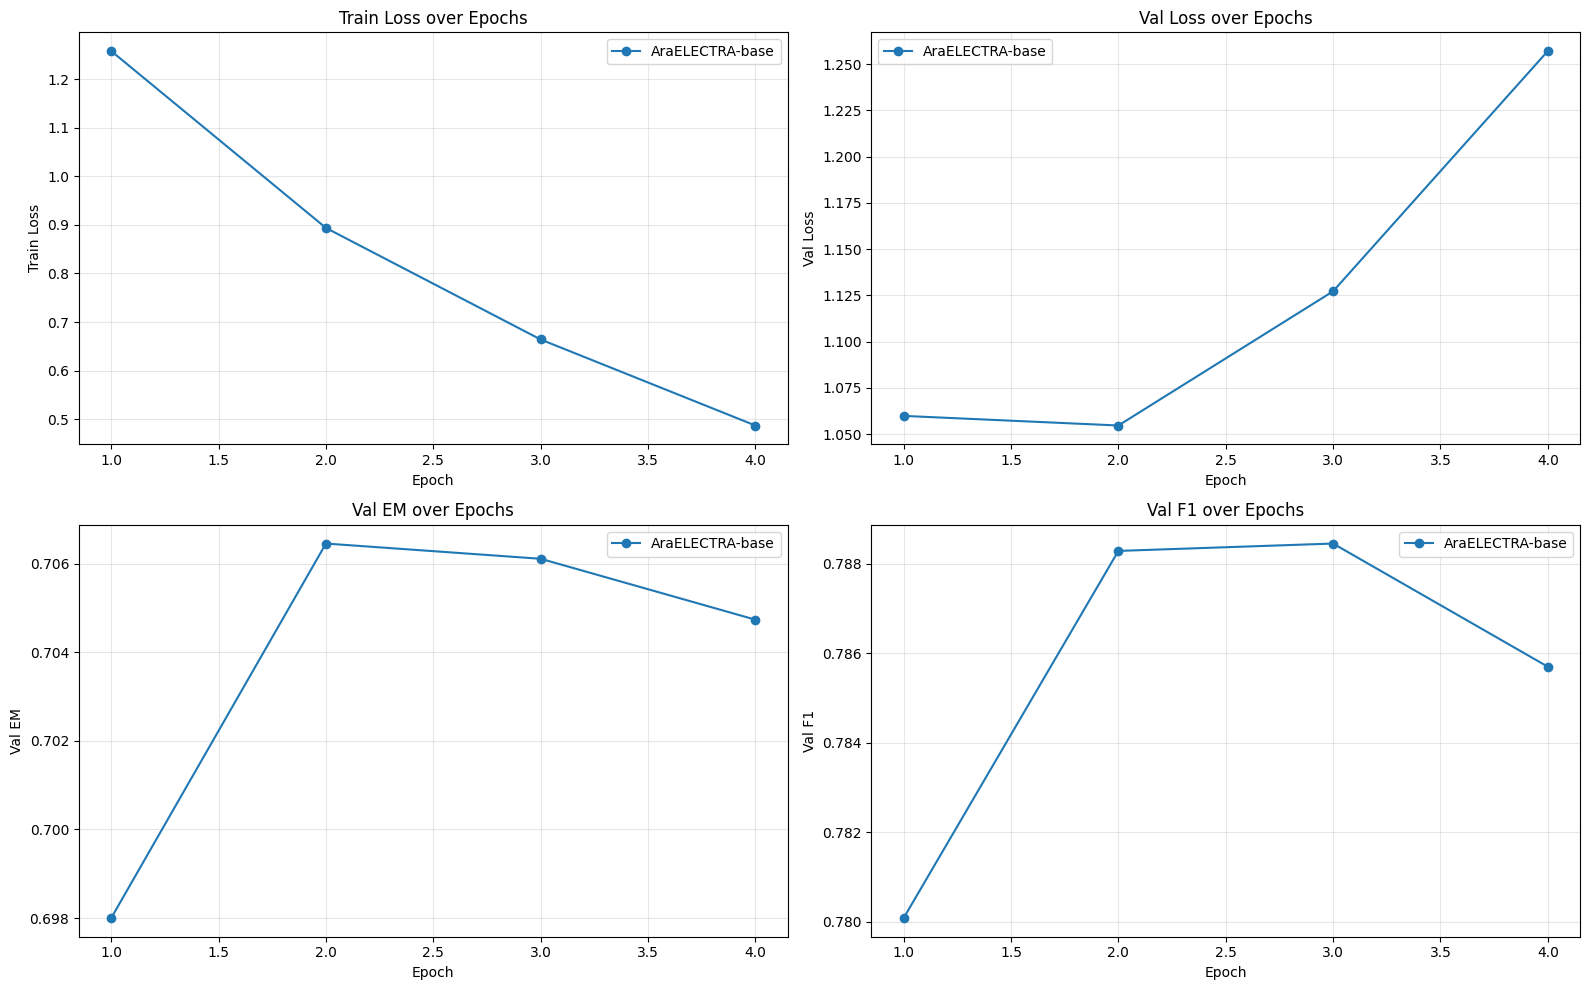

In [13]:
plt.figure(figsize=(16, 10))
for i, (metric_name, metric_key) in enumerate([("Train Loss", "train_losses"), ("Val Loss", "val_losses"), ("Val EM", "val_ems"), ("Val F1", "val_f1s")], 1):
    plt.subplot(2, 2, i)
    for name, res in models_results.items():
        if metric_key in res:
            plt.plot(range(1, len(res[metric_key]) + 1), res[metric_key], marker='o', label=f"{name}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over Epochs")
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
print("\n" + "="*60)
print("Testing best models")
print("="*60)

for name in MODELS_CONFIG.keys():
    print(f"\nTesting {name}...")
    qa = pipeline(
        "question-answering",
        model=f"./best_{name}",
        tokenizer=f"./best_{name}",
        device=0 if torch.cuda.is_available() else -1
    )
    context = "تونس هي دولة تقع في شمال إفريقيا وتعتبر أصغر دولة من حيث المساحة في شمال إفريقيا"
    question = "أين تقع تونس؟"
    out = qa(question=question, context=context)
    print(f"{name}: {out['answer']} (confidence: {out['score']:.4f})")


Testing best models

Testing AraELECTRA-base...
AraELECTRA-base: شمال إفريقيا (confidence: 0.7813)
